In [1]:
import sys
sys.path.append("/home2/sdokania/all_projects/project-noisypixel/")

In [2]:
import os
import glob
import cv2
import random
import pandas as pd
from skimage import io
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import h5py

# Network building stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
import torch.distributions as dist


#mesh
from src.utils.libmise.mise import  MISE
from src.utils.libmcubes.mcubes import marching_cubes
import trimesh

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from src.models import *
from src.dataset.dataloader import OccupancyNetDatasetHDF
from src.trainer import ONetLit
from src.utils import Config, count_parameters

In [5]:
config = Config()
config.data_root = "/ssd_scratch/cvit/sdokania/processed_data/hdf_data/"
config.batch_size = 32
config.output_dir = '../occ_artifacts/'
config.exp_name = 'mesh_exp'
config.encoder = "resnet-50"
config.decoder = "decoder-fc"

Setting sexperiment path as : /home2/sdokania/all_projects/occ_artifacts/initial
Setting sexperiment path as : ../occ_artifacts/mesh_exp


In [6]:
vars(config)

{'c_dim': 128,
 'h_dim': 128,
 'p_dim': 3,
 'data_root': '/ssd_scratch/cvit/sdokania/processed_data/hdf_data/',
 'batch_size': 32,
 'output_dir': '../occ_artifacts/',
 '_exp_name': 'mesh_exp',
 'encoder': 'resnet-50',
 'decoder': 'decoder-fc',
 'lr': 0.0003,
 'exp_path': '../occ_artifacts/mesh_exp'}

In [7]:
onet = ONetLit(config)

In [91]:
# net = ONetLit.load_from_checkpoint("../occ_artifacts/efficient_cbn_bs_64_full_data/lightning_logs/version_1/checkpoints/epoch=103-step=49919.ckpt", cfg=config)
net = ONetLit.load_from_checkpoint("../occ_artifacts/resnet50_fc_bs_64_full_data_balanced//lightning_logs/version_1/checkpoints/epoch=4-step=2399.ckpt", cfg=config)

In [92]:
dataset = OccupancyNetDatasetHDF(config.data_root, num_points=2048)

In [93]:
def make_3d_grid(bb_min, bb_max, shape):
    ''' Makes a 3D grid.
    Args:
        bb_min (tuple): bounding box minimum
        bb_max (tuple): bounding box maximum
        shape (tuple): output shape
    '''
    size = shape[0] * shape[1] * shape[2]

    pxs = torch.linspace(bb_min[0], bb_max[0], shape[0])
    pys = torch.linspace(bb_min[1], bb_max[1], shape[1])
    pzs = torch.linspace(bb_min[2], bb_max[2], shape[2])

    pxs = pxs.view(-1, 1, 1).expand(*shape).contiguous().view(size)
    pys = pys.view(1, -1, 1).expand(*shape).contiguous().view(size)
    pzs = pzs.view(1, 1, -1).expand(*shape).contiguous().view(size)
    p = torch.stack([pxs, pys, pzs], dim=1)

    return p

In [94]:
def eval_points(p, c, points_batch_size=100000):
    """
    """
    p_split = torch.split(p, points_batch_size)
    # print(len(p_split))
    occ_hats = []

    for pi in p_split:
        pi = pi.unsqueeze(0) 
        with torch.no_grad():
            occ_hat = net.net.decoder(pi, c) 
            

        occ_hats.append(occ_hat.squeeze(0).detach().cpu())

    occ_hat = torch.cat(occ_hats, dim=0)

    return occ_hat

In [95]:
def extract_mesh(occ_hat,padding = 0.1,threshold_g = 0.2):
    n_x, n_y, n_z = occ_hat.shape
    box_size = 1 + padding
    threshold = np.log( threshold_g) - np.log(1. - threshold_g)
    
    occ_hat_padded = np.pad(occ_hat, 1, 'constant', constant_values=-1e6)
    print(threshold,occ_hat_padded.shape, np.min(occ_hat_padded), np.max(occ_hat_padded))
    vertices, triangles = marching_cubes(occ_hat_padded, threshold)
  
    vertices -= 0.5
    # Undo padding
    vertices -= 1
    # Normalize to bounding box
    vertices /= np.array([n_x-1, n_y-1, n_z-1])
    vertices = box_size * (vertices - 0.5)
    
    normals = None

    # Create mesh
    mesh = trimesh.Trimesh(vertices, triangles, vertex_normals=normals,process=False)

    return mesh

In [96]:
def get_mesh(dataset, padding=0.01, resolution0=32, upsampling_steps=2, threshold_g=0.2):
    # Get the image, points, and the ground truth
    test_img, test_pts, test_gt = dataset[10]
    
    # Get the threshold and the box padding
    threshold = np.log( threshold_g) - np.log(1. - threshold_g)
    box_size = 1 +  padding
    nx = 32
    pointsf = 2 * make_3d_grid((-0.5,)*3, (0.5,)*3, (nx,)*3    )
    c = net.net.encoder(test_img.unsqueeze(0))#.detach()
    
    if(upsampling_steps==0):
     
        values = eval_points(pointsf,c ).cpu().numpy()
        value_grid = values.reshape(nx, nx, nx)

    else:
        mesh_extractor = MISE(resolution0, upsampling_steps, threshold)
        points = mesh_extractor.query()
 

        while points.shape[0] != 0:
            # Query points
            pointsf = torch.FloatTensor(points) 
            # Normalize to bounding box
            pointsf = pointsf / mesh_extractor.resolution
            pointsf = box_size * (pointsf - 0.5)
            # Evaluate model and update
            print(pointsf.shape, c.shape)
            values = eval_points( pointsf, c).cpu().numpy()


            values = values.astype(np.float64)

            mesh_extractor.update(points, values)
            points = mesh_extractor.query()


        value_grid = mesh_extractor.to_dense()

     
    mesh = extract_mesh(value_grid )
    
    return mesh

In [97]:
# mesh = get_mesh(dataset)


# mesh_out_file = os.path.join('./', '%s.off' % 'onet')
# mesh.export(mesh_out_file)

In [104]:
# Get the image, points, and the ground truth
nux = int(np.random.random()*len(dataset))
test_img, test_pts, test_gt = dataset[nux]

padding=0.1
resolution0=16
upsampling_steps=3
threshold_g=0.5

# Get the threshold and the box padding
threshold = np.log( threshold_g) - np.log(1. - threshold_g)
box_size = 1 +  padding
nx = 32
pointsf = 2 * make_3d_grid((-0.5,)*3, (0.5,)*3, (nx,)*3    )
c = net.net.encoder(test_img.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


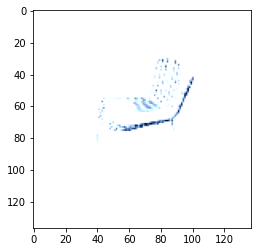

In [105]:
plt.imshow(test_img.transpose(0, 1).transpose(1, 2))

In [106]:
nux

20580

In [107]:
# upsampling_steps=0
print(threshold)

0.0


In [108]:

if(upsampling_steps==0):

    values = eval_points(pointsf,c ).cpu().numpy()
    value_grid = values.reshape(nx, nx, nx)

else:
    mesh_extractor = MISE(resolution0, upsampling_steps, threshold)
    points = mesh_extractor.query()


    while points.shape[0] != 0:
        # Query points
        pointsf = torch.FloatTensor(points) 
        # Normalize to bounding box
        pointsf = pointsf / mesh_extractor.resolution
        pointsf = box_size * (pointsf - 0.5)
        # Evaluate model and update
        print(pointsf.shape, c.shape)
        values = eval_points(pointsf, c).cpu().numpy()


        values = values.astype(np.float64)

        mesh_extractor.update(points, values)
        points = mesh_extractor.query()


    value_grid = mesh_extractor.to_dense()


# mesh = extract_mesh(value_grid )

torch.Size([4913, 3]) torch.Size([1, 128])
torch.Size([8216, 3]) torch.Size([1, 128])
torch.Size([33681, 3]) torch.Size([1, 128])
torch.Size([135348, 3]) torch.Size([1, 128])
torch.Size([425, 3]) torch.Size([1, 128])
torch.Size([248, 3]) torch.Size([1, 128])
torch.Size([10, 3]) torch.Size([1, 128])


In [109]:
 mesh = extract_mesh(value_grid )

-1.3862943611198906 (131, 131, 131) -1000000.0 3.461782693862915


In [110]:
mesh_out_file = os.path.join('./', '%s.off' % 'onet')
opf = mesh.export(mesh_out_file)

/home2/sdokania/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

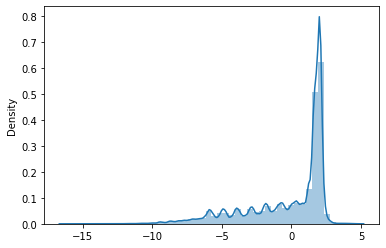

In [90]:
sns.distplot(value_grid.flatten())

<ipython-input-48-fd0628239959>:2: RuntimeWarning: divide by zero encountered in log
  y = np.log(x) - np.log(1 - x)


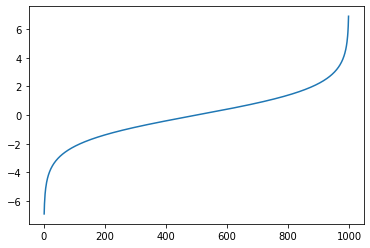

In [48]:
x = np.linspace(0, 1, 1000)
y = np.log(x) - np.log(1 - x)

plt.plot(y)

/home2/sdokania/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

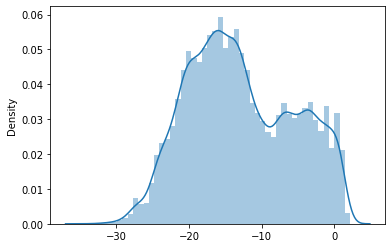

In [28]:
# old_values = values.copy()
sns.distplot(old_values)

In [362]:
class OccupancyNetDatasetHDF(Dataset):
    """Occupancy Network dataset."""

    def __init__(self, root_dir, transform=None, num_points=1024, default_transform=True, mode="train"):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
            num_points (int): Number of points to sample in the object point cloud from the data
                on a sample.
            mode (str): Which data split do we want among train, test and val
        """
        self.root_dir = root_dir
        self.transform = transform
        self.num_points = num_points
        self.mode = mode
        self.files = []
        self.pos_neg_ratio = [0.1, 0.5]
        
        # Save the files
        f = open(os.path.join(self.root_dir, "{}.lst".format(self.mode)), 'r')
        self.files = f.read().split()
        f.close()
            
        # If not transforms have been provided, apply default imagenet transform
        if transform is None and default_transform:
            self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.files)
    
    def get_prob(self):
        return self.pos_neg_ratio[0] + (np.random.random() * (self.pos_neg_ratio[1] - self.pos_neg_ratio[0]))

    def __getitem__(self, idx):
        # Fetch the file path and setup image folder paths
        req_path = self.files[idx]
        file_path = os.path.join(self.root_dir, req_path)

        # Load the h5 file
        hf = h5py.File(file_path, 'r')
        
        # [NOTE]: the notation [()] below is to extract the value from HDF5 file
        # get all images and randomly pick one
        all_imgs = hf['images'][()]
        random_idx = int(np.random.random()*all_imgs.shape[0])
        
        # Fetch the image we need
        image = all_imgs[random_idx]
        try:
            # Get the points and occupancies
            points = hf['points']['points'][()]
            occupancies = np.unpackbits(hf['points']['occupancies'][()])
            
            # Create index list
            indices = np.arange(occupancies.shape[0])
            
            n_pos = int(self.num_points * self.get_prob())
            n_neg = self.num_points - n_pos
            positive_idx = np.random.permutation(indices[occupancies == 1])[:n_pos]
            negative_idx = np.random.permutation(indices[occupancies == 0])[:n_neg]
            
            # Sample n points from the data
            # selected_idx = np.random.permutation(np.arange(points.shape[0]))[:self.num_points]
            selected_idx = np.concatenate([positive_idx, negative_idx])

            # Use only the selected indices and pack everything up in a nice dictionary
            final_image = torch.from_numpy(image).float().transpose(1, 2).transpose(0, 1) / image.max()
            final_points = torch.from_numpy(points[selected_idx]).float()
            final_gt = torch.from_numpy(occupancies[selected_idx]).float()
        except:
            print(idx, file_path)
        
        # Close the hdf file
        hf.close()
        
        # Apply any transformation necessary
        if self.transform:
            final_image = self.transform(final_image)

        return [final_image, final_points, final_gt, occupancies]

In [363]:
dataset = OccupancyNetDatasetHDF(config.data_root, num_points=2048, mode="val")

In [374]:
a, b, c, d = dataset[10]
(c == 1).sum() / c.shape[0]

tensor(0.3379)

tensor(1918)

In [321]:
# indices = np.arange(d.shape[0])
np.random.random() *

0.6423318215176403

In [262]:
np.random.permutation(indices[d == 1])[:10]

array([77821, 31491, 32593, 41948, 43122, 27024, 19922, 78694, 23035,
       40838])